In [1]:
import pandas as pd 

In [2]:
#판다스 출력 결과를 소수점 둘째 자리까지로 제한!
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
sales_df = pd.read_csv('data/sales_data.csv', index_col =['customer_id'])
sales_df

,total_buy_cnt,total_price
customer_id,,
12395,99,430250
12427,98,566410
12431,122,849900
12433,625,1180950
12471,10,97750
...,...,...
18144,30,90750
18168,243,1533530
18225,1,91430


# 이상치 제거

In [4]:
import seaborn as sns
sns.set(style='darkgrid', rc= {'figure.figsize':(16,9)})

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

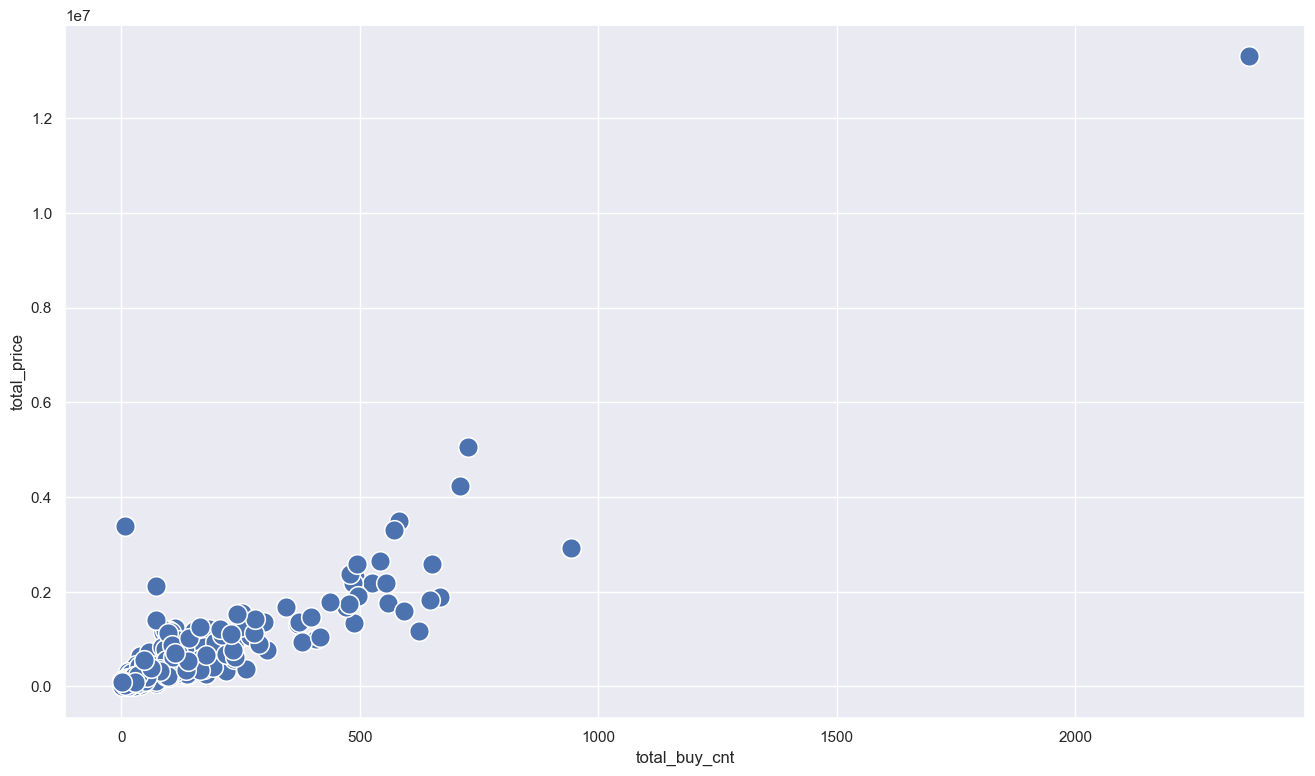

In [5]:
sns.scatterplot(x = sales_df['total_buy_cnt'],
               y = sales_df['total_price'],
               s = 200)

In [6]:
def get_outlier_mask(df, weight= 1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    IQR = Q3 - Q1
    IQR_weight = IQR*weight
    
    range_min = Q1 - IQR_weight
    range_max = Q3 + IQR_weight
    
    outlier_per_column = (df < range_min) | (df > range_max)
    is_outlier = outlier_per_column.any(axis =1)
    
    return is_outlier

In [7]:
outlier_df_cust_df = get_outlier_mask(sales_df, weight =1.5)

In [8]:
sales_df = sales_df[~outlier_df_cust_df]

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

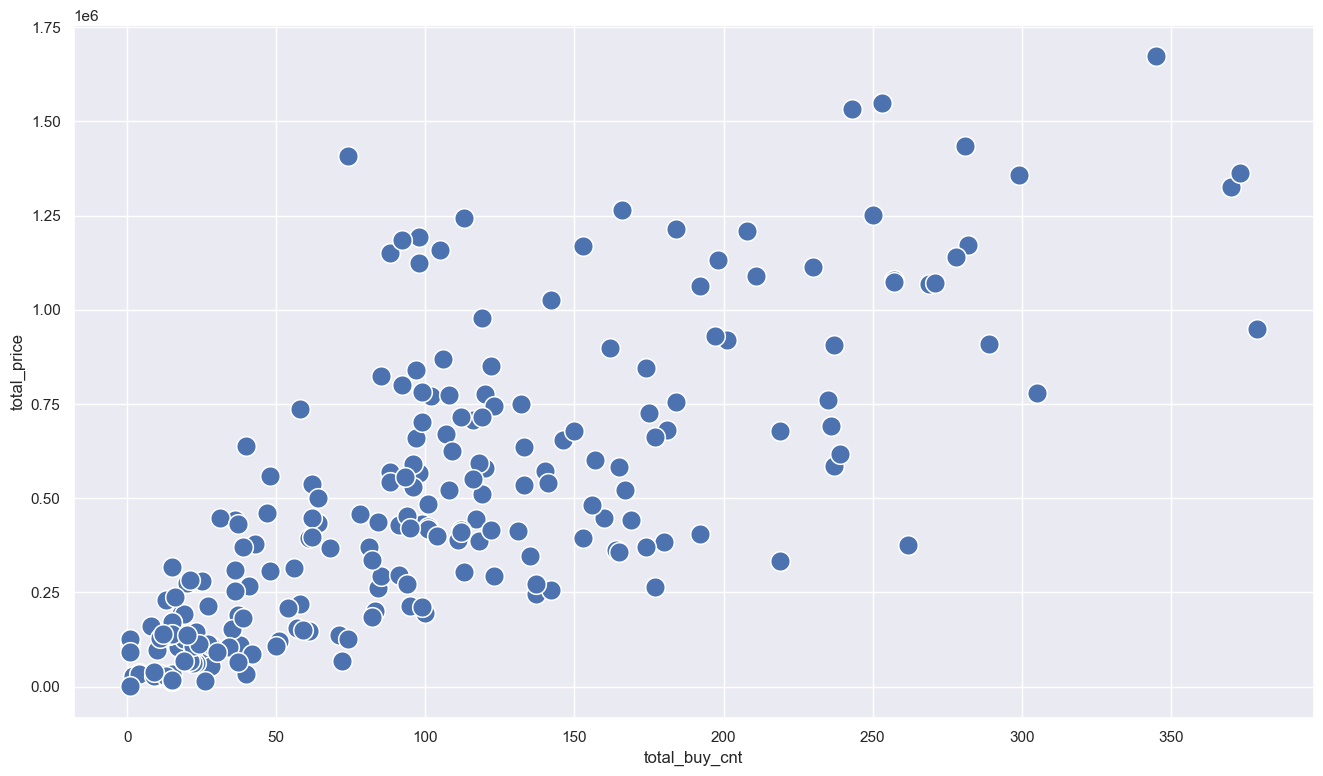

In [9]:
sns.scatterplot(x=sales_df['total_buy_cnt'],
               y=sales_df['total_price'],
               s = 200)

# 데이터 표준화
데이터를 보면 total_buy_cnt는 단위가 1개이고, 가장 큰 값은 350개입니다.

하지만, total_price는 기본 단위가 10,000원입니다. 두 변수의 단위가 많이 차이나네요.

표준화를 하면 평균이 0, 분산은 1로 값이 조정되어 단위가 통일되는 효과


https://www.codeit.kr/community/questions/UXVlc3Rpb246NjRiMmMwODI4NzFhM2YzOTg2NGU2MzI2표준화된  
데이터를 KMeans모델에 학습시키는 이유는 k-means는 각 feature의 스케일에 민감하기 때문입니다.

KMeans에서 클러스터 중심 (centroid)을 계산한다는 것은 결국 거리의 제곱합이 최소가 되는 지점을 찾는 과정입니다.



만약, 각 feature의 스케일이 다른 경우, 거리를 계산하는 과정에서 스케일 크기가 큰 feature가 더 큰 영향을 미칠 수 있고, 이는 클러스터링 결과가 제대로 이뤄지지 않는 것으로 이어질 수 있습니다.


예컨대, 'total_buy_cnt'와 'total_price'가 있을 때,   
'total_buy_cnt'는 1-100 사이의 값이고,   
'total_price'는 100-100000000 사이의 값이라면,   
'total_price'가 훨씬 큰 스케일을 가지는 만큼 각 점에서 거리를 계산할 때  
'total_price'의 차이가 훨씬 더 큰 영향을 미칠 수 있고,   
상대적으로 'total_buy_cnt'에 대한 정보는 무시될 수 있습니다.



따라서, 일반적인 경우에는 표준화된 자료를 이용해서 구한 centroid가 더 타당하다고 볼 수 있을 것 같습니다. (특수하게, scale이 큰 변수가 더 중요한 의미를 가진다거나... 하는 경우가 아니라면 말입니다.) 오히려, 반대로 scale을 하지 않고 k-means를 한다면 "변수간의 scale에 따라서 k-means에 미치는 영향이 달라질텐데 이 부분을 고려한 것이냐?"라는 질문에 디펜스를 해야 할 것 같습니다.



In [10]:
print(sales_df.min())
print(sales_df.max())

total_buy_cnt      1
total_price      350
dtype: int64
total_buy_cnt        379
total_price      1672130
dtype: int64


In [11]:
df_mean = sales_df.mean() #각 칼럼 평균
df_std = sales_df.std() #각 칼럼 표준편차

## 칼럼별 표준화 진행

In [12]:
scaled_df = (sales_df - df_mean) / df_std

In [13]:
scaled_df.columns = ['total_buy_cnt', 'total_price']

In [14]:
scaled_df.index = scaled_df.index
scaled_df

,total_buy_cnt,total_price
customer_id,,
12395,-0.05,-0.15
12427,-0.07,0.21
12431,0.23,0.95
12471,-1.13,-1.02
12472,-0.19,0.21
...,...,...
18144,-0.89,-1.04
18168,1.69,2.74
18225,-1.24,-1.04


# k-means 모델 학습 및 시각화

In [15]:
from sklearn.cluster import KMeans

In [16]:
# k-means(k=2)
model = KMeans(n_clusters=2, random_state=123)
# 모델 학습
model.fit(scaled_df)

C:\Users\semin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\semin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, random_state=123)

In [17]:
# label 컬럼 생성
scaled_df['label'] = model.predict(scaled_df)

scaled_df


,total_buy_cnt,total_price,label
customer_id,,,
12395,-0.05,-0.15,0
12427,-0.07,0.21,0
12431,0.23,0.95,1
12471,-1.13,-1.02,0
12472,-0.19,0.21,0
...,...,...,...
18144,-0.89,-1.04,0
18168,1.69,2.74,1
18225,-1.24,-1.04,0


In [18]:
#각 군집의 중심점
centers = model.cluster_centers_
centers

array([[-0.56813571, -0.61752811],
       [ 0.93575293,  1.01710512]])

In [19]:
centers[:,0]

array([-0.56813571,  0.93575293])

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

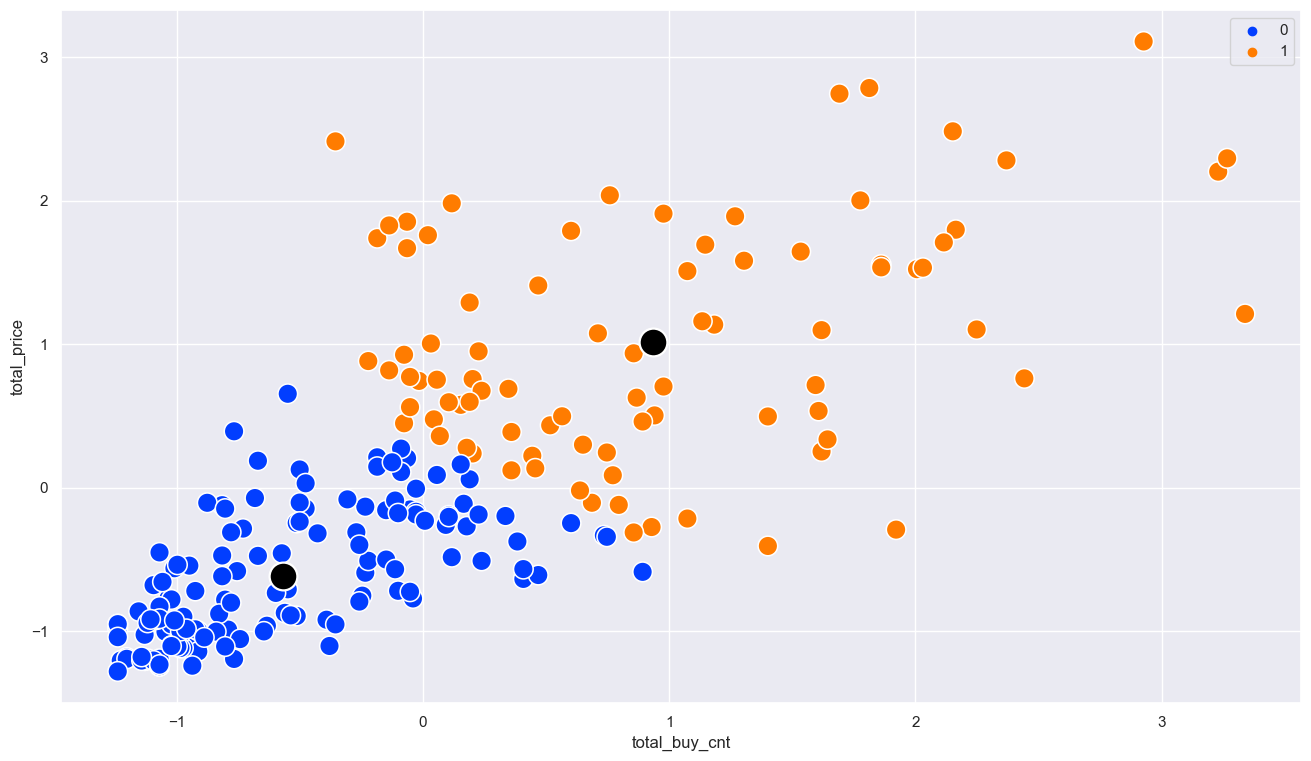

In [20]:
sns.scatterplot(x=scaled_df['total_buy_cnt'],
               y= scaled_df['total_price'],
               hue=scaled_df['label'],
               s=200,
               palette='bright')

sns.scatterplot(x=centers[:,0],
               y= centers[:,1],
               color='black',
               s=400)

# 결과 해석하기 

In [21]:
model = KMeans(n_clusters=5, random_state=123)
model.fit(scaled_df)

C:\Users\semin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\semin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=123)

In [22]:
sales_df['label'] = model.predict(scaled_df)

C:\Users\semin\AppData\Local\Temp\ipykernel_37972\3058466036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['label'] = model.predict(scaled_df)


In [40]:
sales_df['label'].head()

customer_id
12395    4
12427    4
12431    2
12471    0
12472    4
Name: label, dtype: int32

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

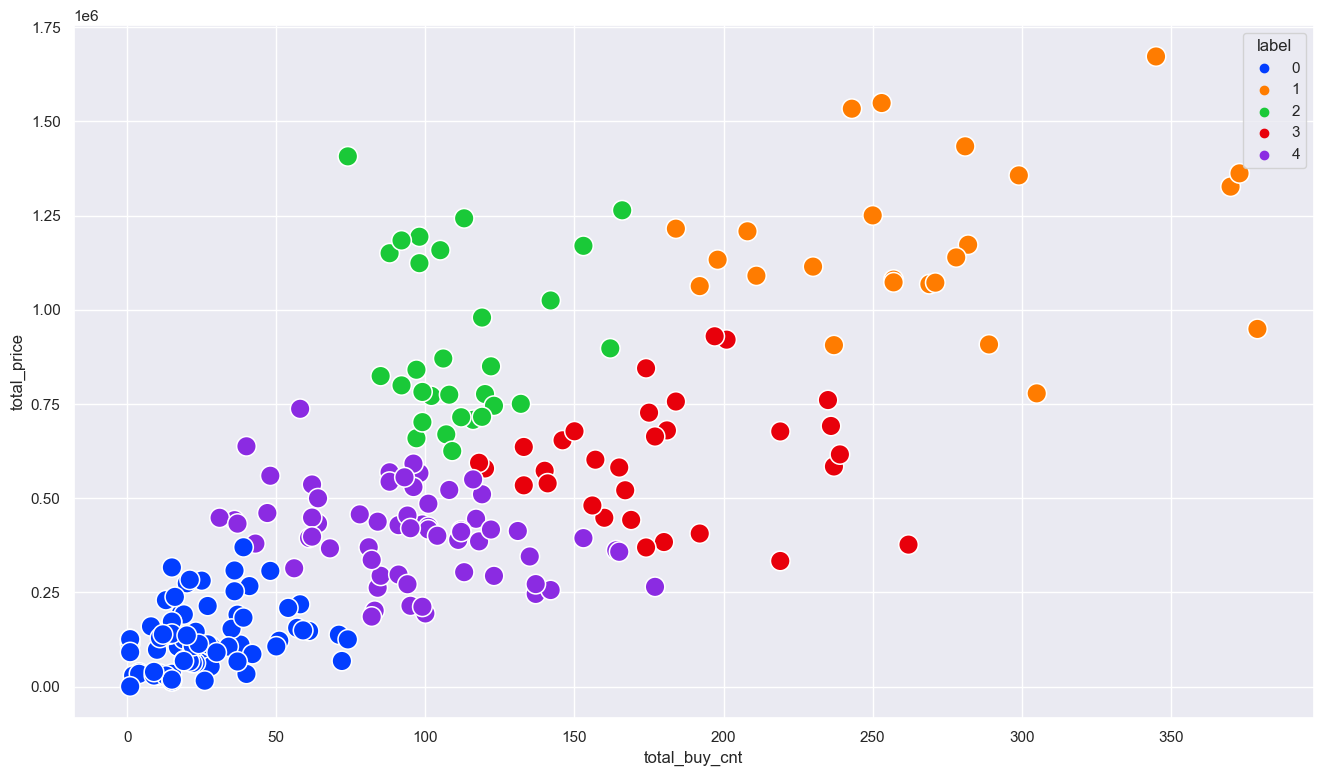

In [24]:
sns.scatterplot(x=sales_df['total_buy_cnt'],
               y=sales_df['total_price'],
               hue=sales_df['label'],
               s = 200,
               palette='bright')

In [25]:
#각 클러스터에 속해 있는 고객 수 
sales_df['label'].value_counts()

0    77
4    63
3    31
2    30
1    24
Name: label, dtype: int64

In [26]:
groupby_df = sales_df.groupby('label').mean()
groupby_df

,total_buy_cnt,total_price
label,,
0,25.64,"127,196.23"
1,269.21,"1,185,537.08"
2,111.83,"912,418.33"
3,178.61,"599,421.61"
4,94.19,"406,160.63"


In [27]:
groupby_df['price_mean'] = groupby_df['total_price']/groupby_df['total_buy_cnt']
groupby_df

,total_buy_cnt,total_price,price_mean
label,,,
0,25.64,"127,196.23","4,961.56"
1,269.21,"1,185,537.08","4,403.79"
2,111.83,"912,418.33","8,158.73"
3,178.61,"599,421.61","3,355.98"
4,94.19,"406,160.63","4,312.12"


In [29]:
# from sklearn.cluster import KMeans
# model = KMeans(n_clusters=k, init='k-means++')


# 계층적 클러스터링 

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt

In [31]:
#거리:ward method
model = linkalikge(scaled_df, 'ward')

In [33]:
labelList = scaled_df.index

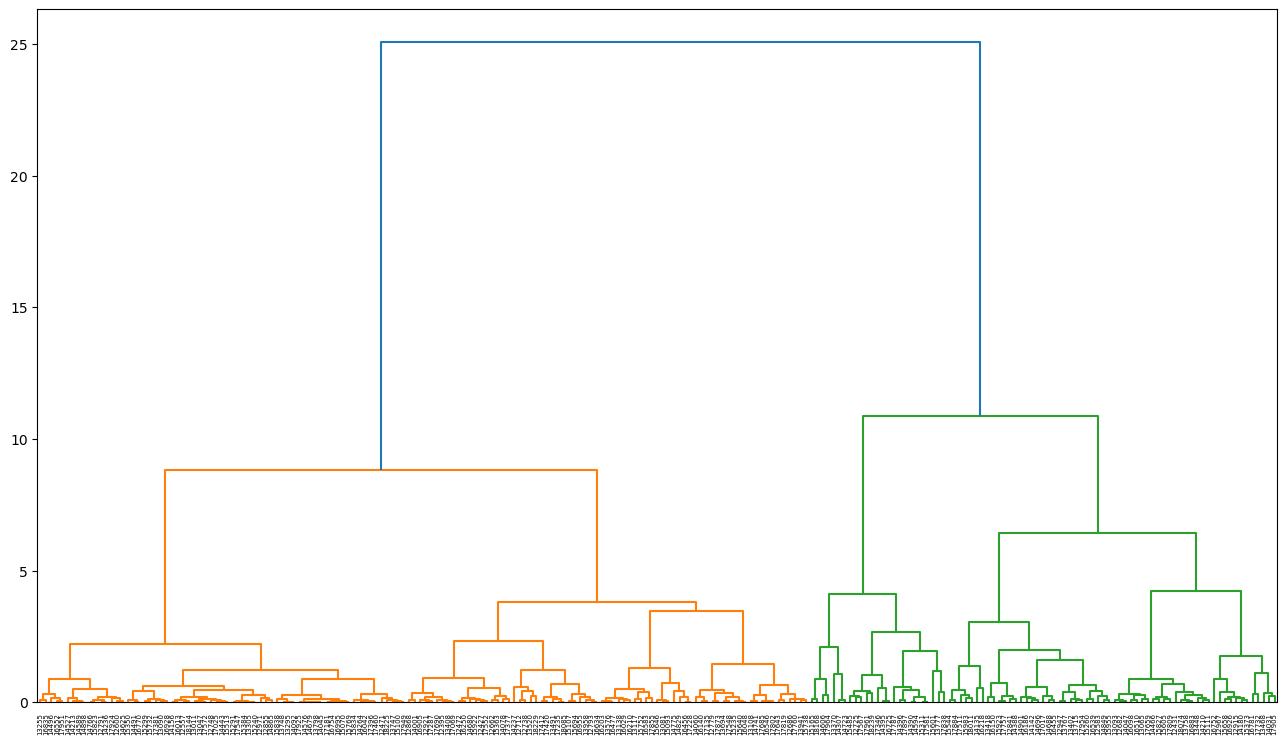

In [36]:
plt.figure(figsize=(16,9))
plt.style.use('default')

dendrogram(model, labels=labelList)
plt.show()

## 클러스터 5개로 나눠보고, 클러스별로 고객 몇 명씩 속해 있는지

In [37]:
cluster_num =5

scaled_df['label'] = cut_tree(model, cluster_num)
scaled_df['label']

customer_id
12395    0
12427    0
12431    1
12471    2
12472    0
        ..
18144    2
18168    4
18225    2
18229    0
18239    4
Name: label, Length: 225, dtype: int32

In [39]:
pd.DataFrame(scaled_df['label'].value_counts())

,label
0,73
2,67
1,30
3,30
4,25


## 시각화하기

In [41]:
sns.set(style='darkgrid',
       rc= {'figure.figsize':(16,9)})

<Axes: xlabel='total_price', ylabel='total_buy_cnt'>

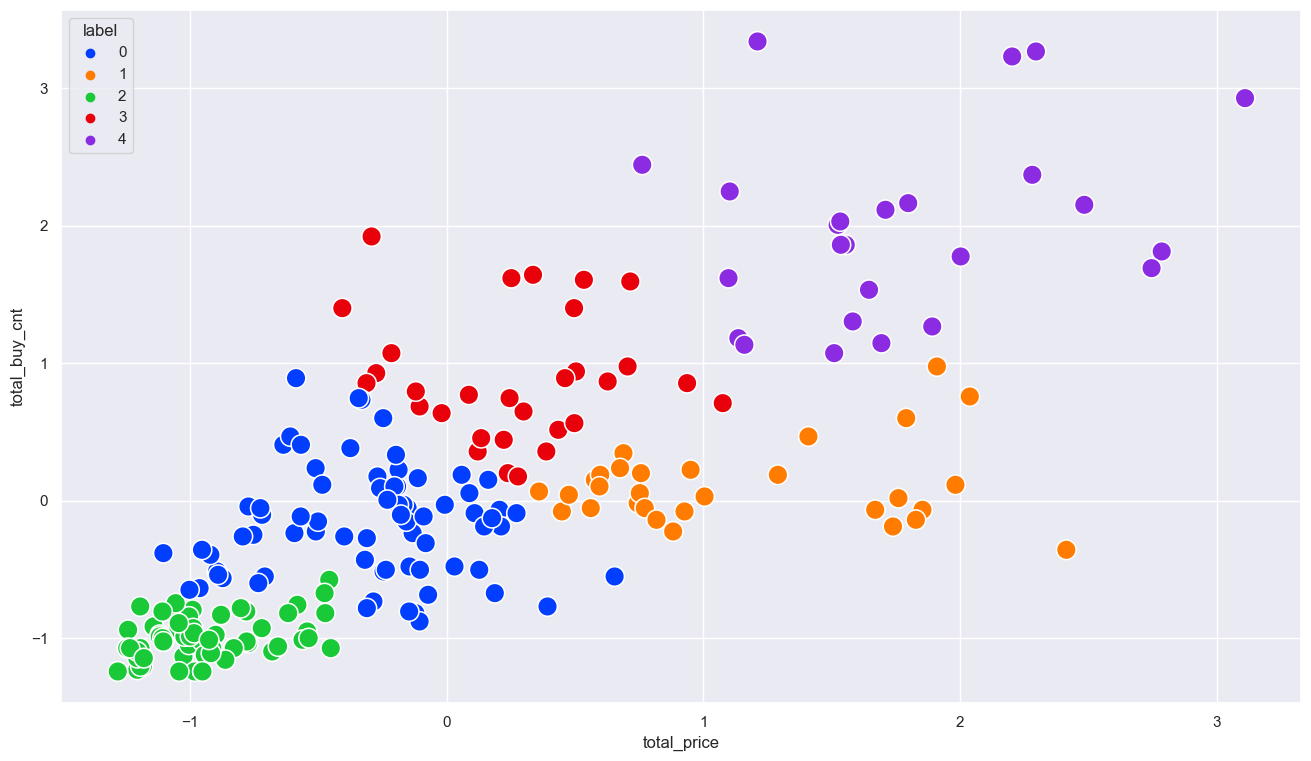

In [45]:
sns.scatterplot(x=scaled_df['total_price'], y=scaled_df['total_buy_cnt'], hue=scaled_df['label'],
               s=200, palette='bright')